## Roman Time Domain deep-field spec-z efficiency plot

This notebook constructs a redshift efficiency figure from the .DUMP file output of a SNANA simulation of the Roman time domain survey. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import glob
import math
import yaml
import os
from astropy.table import Table


plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 19
plt.rcParams['legend.borderpad'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
#plt.rcParams['legend.markerscale'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.minor.size']  =  1.5     # major tick size in points
plt.rcParams['ytick.minor.size'] =   1.5     # major tick size in points

%matplotlib inline


In [2]:
def read_dump_file(filename, maxlines=None):
    """Read a SNANA .DUMP file into an astropy Table object"""
    if maxlines is not None:
        tab = Table.read(filename, format='ascii.basic', header_start=0, data_start=1, data_end=maxlines)
    else:
        tab = Table.read(filename, format='ascii.basic', header_start=0, data_start=1)        
    return tab

### Read in the SNANA data  

And limit  to only  the DEEP field data set

In [3]:
roman = read_dump_file("data/PIP_WFIRST_EFFICIENCY_WFIRST_ROMAN_DEEP_G10_SEARCHEFF_0.DUMP", maxlines=None)
subaru = read_dump_file("data/PIP_WFIRST_EFFICIENCY_WFIRST_SUBARU_G10_SEARCHEFF_0.DUMP", maxlines=None) 
#combined = read_dump_file("data/PIP_WFIRST_STARTERKIT+SETEXP_WFIRST_SIMDATA_G10.DUMP", maxlines=None)

romanfieldmask = (roman['FIELD']=='DEEP')
roman = roman[romanfieldmask]

subarufieldmask = (subaru['FIELD']=='DEEP')
subaru = subaru[subarufieldmask]

### View the Ia and CC Host populations

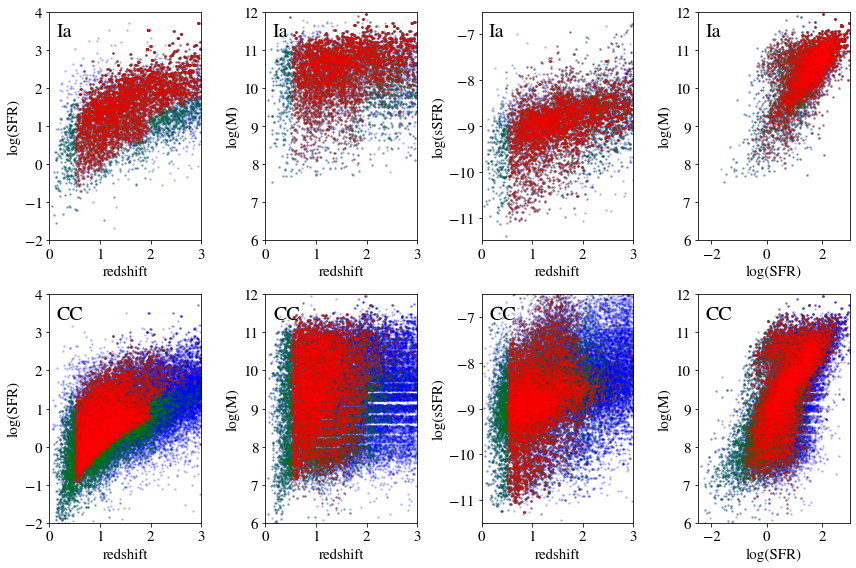

In [4]:
fig = plt.figure(figsize=[12,8])  

for sntype, axrow in zip(['Ia','CC'],[0,1]):

    ax1 = fig.add_subplot(2,4,axrow*4+1)
    ax2 = fig.add_subplot(2,4,axrow*4+2)
    ax3 = fig.add_subplot(2,4,axrow*4+3)
    ax4 = fig.add_subplot(2,4,axrow*4+4)

    if sntype=='Ia':
        explmask = roman['NON1A_INDEX']==0
        detmask = (roman['NON1A_INDEX']==0) & (roman['SIM_SEARCHEFF_MASK']>0)
        hostzmask = (roman['NON1A_INDEX']==0) & (roman['SIM_SEARCHEFF_MASK']>4)
    else:
        explmask = roman['NON1A_INDEX']>0
        detmask = (roman['NON1A_INDEX']>0) & (roman['SIM_SEARCHEFF_MASK']>0)
        hostzmask = (roman['NON1A_INDEX']>0) & (roman['SIM_SEARCHEFF_MASK']>4)
    
    for mask,color in zip([explmask, detmask, hostzmask], ['b','g','r']):
        sfr = roman[mask]['logsfr']
        ztruee = roman[mask]['ZTRUE']
        zcmb = roman[mask]['ZCMB']
        mass = roman[mask]['logmass']
        ssfr = sfr - mass
        
        ax1.plot(zcmb, sfr, color=color, ls=' ', alpha=0.2, marker='.', ms=3)
        ax2.plot(zcmb, mass, color=color, ls=' ', alpha=0.2, marker='.', ms=3)
        ax3.plot(zcmb, ssfr, color=color, ls=' ', alpha=0.2, marker='.', ms=3)
        ax4.plot(sfr, mass, color=color, ls=' ', alpha=0.2, marker='.', ms=3)

    ax1.set_xlabel('redshift')
    ax1.set_ylabel('log(SFR)')
    ax2.set_xlabel('redshift')
    ax2.set_ylabel('log(M)')
    ax3.set_xlabel('redshift')
    ax3.set_ylabel('log(sSFR)')
    ax4.set_xlabel('log(SFR)')
    ax4.set_ylabel('log(M)')

    ax1.text(0.05, 0.95, sntype, fontsize=20, ha='left', va='top', transform=ax1.transAxes)
    ax2.text(0.05, 0.95, sntype, fontsize=20, ha='left', va='top', transform=ax2.transAxes)
    ax3.text(0.05, 0.95, sntype, fontsize=20, ha='left', va='top', transform=ax3.transAxes)
    ax4.text(0.05, 0.95, sntype, fontsize=20, ha='left', va='top', transform=ax4.transAxes)

    ax1.set_xlim(0, 3)
    ax1.set_ylim(-2, 4)
    ax2.set_xlim(0, 3)
    ax2.set_ylim(6, 12)
    ax3.set_xlim(0, 3)
    ax3.set_ylim(-11.5, -6.5)
    ax4.set_xlim(-2.5, 3)
    ax4.set_ylim(6, 12)

plt.tight_layout()

### Some quick counts of detected SN 

In [5]:
ccmask = roman['NON1A_INDEX']>0
ccdetmask = (roman['NON1A_INDEX']>0) & (roman['SIM_SEARCHEFF_MASK']>0)
cchostzmask = (roman['NON1A_INDEX']>0) & (roman['SIM_SEARCHEFF_MASK']>4)

iamask = roman['NON1A_INDEX']==0
iadetmask = (roman['NON1A_INDEX']==0) & (roman['SIM_SEARCHEFF_MASK']>0)
iahostzmask = (roman['NON1A_INDEX']==0) & (roman['SIM_SEARCHEFF_MASK']>4)

nexpIa_roman = np.sum(iamask)
nexpCC_roman = np.sum(ccmask)

ndetIa_roman = np.sum(iadetmask)
ndetCC_roman = np.sum(ccdetmask)

nhostzCC_roman = np.sum(cchostzmask)
nhostzIa_roman = np.sum(iahostzmask)

print("    Explosions  Detections  GotSpecz")
print("Ia: {:10,d} {:10,d} {:10,d}".format(nexpIa_roman, ndetIa_roman, nhostzIa_roman))
print("CC: {:10,d} {:10,d} {:10,d}".format(nexpCC_roman, ndetCC_roman, nhostzCC_roman))

    Explosions  Detections  GotSpecz
Ia:      8,742      7,313      6,208
CC:     38,628     16,616     12,061


### exploratory  summary plot

Shows two ways of computing the 'specz efficiency'.

The  grey histogram is all the simulated SNIa that SNANA reports.
Blue is the photometric detections (SIM_SEARCHEFF_MASK>0)
Red is  those that are photometrically detected and also get a specz (SIM_SEARCHEFF_MASK==5)
The solid line in black is the efficiency computed as Red / Blue : the fraction of detected SNIa that also get a hostz. (read the efficiency values from the y axis on the right side)
The dashed line is the efficiency computed as Red / gray : the fraction of all SNIa explosions that are both detected and get a host specz.

We see that the dashed line efficiency is always lower, and drops faster at high z, reflecting both the fact that it gets harder to get a specz, but also that its harder to find the SNIa in the first place.   I think the curve we should be showing here is the solid line, b/c that is reflecting our estimate of the fraction of the detected SNIa sample that will have a specz, which  is the measurable metric, and the one that would be widely understood as the "spectroscopic redshift recovery efficiency"

Note that I don't really understand what is going on with the CC plot.  Why would the roman grism be so much less efficient at measuring specz for CC SN host galaxies at high redshift?

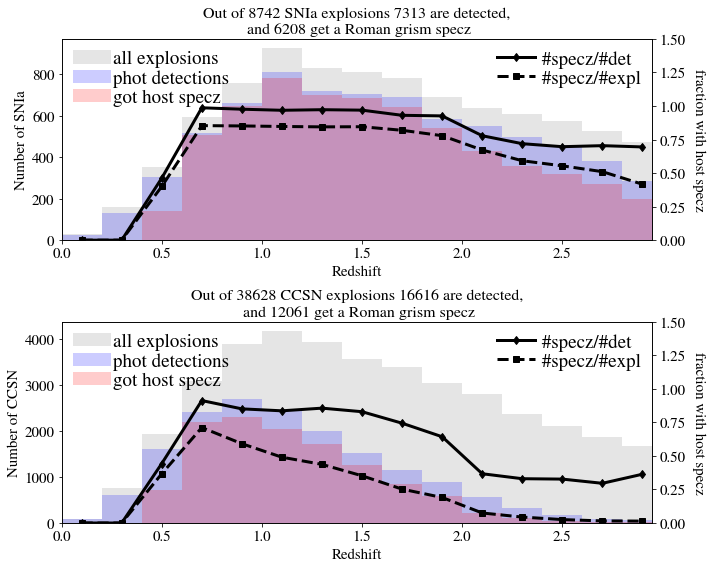

In [6]:
def make_plot_summary(sntype='Ia', ax=None):
    if ax is None:
        ax = plt.gca()
    if sntype=='Ia':
        explmask = roman['NON1A_INDEX']==0
        detmask = (roman['NON1A_INDEX']==0) & (roman['SIM_SEARCHEFF_MASK']>0)
        specmask = (roman['NON1A_INDEX']==0) & (roman['SIM_SEARCHEFF_MASK']>1)
        sntypetext = 'SNIa'
    elif sntype=='CC':
        explmask = roman['NON1A_INDEX']>0
        detmask = (roman['NON1A_INDEX']>0) & (roman['SIM_SEARCHEFF_MASK']>0)
        specmask = (roman['NON1A_INDEX']>0) & (roman['SIM_SEARCHEFF_MASK']>1)
        sntypetext = 'CCSN'

    bins = np.arange(0,3.04,0.2)
    nexpl = int(np.sum(explmask))
    ndet = int(np.sum(detmask))
    nspecz = int(np.sum(specmask))
    
    histout0 = ax.hist(roman['ZCMB'][explmask], color='k', alpha=0.1, bins=bins, label='all explosions')
    histout1 = ax.hist(roman['ZCMB'][detmask], color='b', alpha=0.2, bins=bins, label='phot detections')
    histout2 = ax.hist(roman['ZCMB'][specmask], color='r', alpha=0.2, bins=bins, label='got host specz')

    ax.set_title(f'Out of {nexpl:d} {sntypetext} explosions {ndet:d} are detected,\n and {nspecz:d} get a Roman grism specz', fontsize=16)
    ax.legend(loc='upper left')

    ax2 = ax.twinx()

    speczeff0 = histout2[0] / histout0[0]  # no.specz /  no.explosions
    speczeff1 = histout2[0] / histout1[0]  #  no.specz / no.phot-detections
    binmidpts = (histout2[1][1:] + histout2[1][:-1])/2.
    ax2.plot(binmidpts, speczeff1, marker='d', ls='-', color='k', lw=3, label=' #specz/#det')
    ax2.plot(binmidpts, speczeff0, marker='s', ls='--', color='k', lw=3, label=' #specz/#expl')
    ax2.legend(loc='upper right')

    ax2.set_ylabel("fraction with host specz", rotation=-90, labelpad=20)
    ax.set_ylabel(f"Number of {sntypetext}")
    ax.set_xlabel('Redshift')

    ax.set_xlim(0, 2.95)
    ax2.set_ylim(0, 1.5)
    
    
fig = plt.figure(figsize=[10,8])
axIa = fig.add_subplot(2,1,1)
make_plot_summary(sntype='Ia', ax=axIa)

axCC = fig.add_subplot(2,1,2)
make_plot_summary(sntype='CC', ax=axCC)
plt.tight_layout()


# Making the Redshift Efficiency Figure:

In [7]:
def plot_efficiency_vs_z(dat, bins=np.arange(0,3.01,0.1), ax=None, **kwargs):
    """Plot the redshift measurement efficiency vs redshift for 
    the given (subset) of the SNANA sim data. 
    
    dat : an astropy Table, read from a SNANA .DUMP file  This function presumes 
       the user has made all desired selection cuts to the data, such as limiting 
       to the FIELD of interest or selecting a specific SN subclass using the NON1A_INDEX
    ax : the axes to plot on. Use None to use current axes or make new.
    bins : passed to np.histogram()
    kwargs : passed to plt.plot()
    """
    if ax is None:
        ax = plt.gca()

    detmask = dat['SIM_SEARCHEFF_MASK']>0   # All photometrically detected SNe
    speczmask = dat['SIM_SEARCHEFF_MASK']>4   # All detected SNe that get a specz
       
    num_det  = np.histogram(dat['ZCMB'][detmask], bins=bins)[0]
    num_specz, bin_edges  = np.histogram(dat['ZCMB'][speczmask], bins=bins)

    midpt = (bin_edges[1:]+bin_edges[:-1])/2.
    speczefficiency = num_specz / num_det

    ax.plot(midpt, speczefficiency, **kwargs)
    return    

In [12]:
def make_hostz_efficiency_fig(roman, subaru, sntype='Ia', field='DEEP', scalefactor=1,
                             showseechange=True):
    """Construct a figure showing the host spectroscopic redshift measuremnet 
    efficiency curves for Type Ia (sntype='Ia') or CC SN (sntype='CC'). 
    
    scalefactor : fudge factor to rescale the reported counts of SNe in the survey. For example, 
       so that it matches the count of total SNe produced in a different survey sim.
    
    """

    fig = plt.figure(figsize=[8,4])
    ax1 = fig.add_subplot(1,1,1)
    ax2 = ax1.twinx()

    if field != 'DEEP' and field != 'SHALLOW':
        raise RuntimeError(f"field={field} is not known.")
        
    # Limit to only the field of interest DEEP or SHALLOW (meaning 'wide')
    # and the SN sub-class of interest 
    if sntype == 'Ia':
        hist_tick_step = 200
        xgrismtext=2.08
        ygrismtext=1.05
        xalltext=0.95
        yalltext=0.25
        mfc=None
        typestr = 'SNIa'
        romanmask = (roman['NON1A_INDEX']==0) & (roman['FIELD']==field)
        subarumask = (subaru['NON1A_INDEX']==0) & (subaru['FIELD']==field)
    elif sntype == 'CC':
        hist_tick_step = 800
        xgrismtext=1.2
        ygrismtext=0.85
        xalltext=1.45
        yalltext=0.55
        mfc='w'
        typestr = 'CCSN'
        romanmask = (roman['NON1A_INDEX']!=0) & (roman['FIELD']==field)
        #romanwidemask = (roman['NON1A_INDEX']!=0) & (roman['FIELD']==field)
        subarumask = (subaru['NON1A_INDEX']!=0) & (subaru['FIELD']==field)
    else:
        raise RuntimeError(f"sntype={sntype} is not known.")
   
    roman = roman[romanmask]
    subaru = subaru[subarumask]
    
    # get approximate counts of detections and spectroscopic redshifts (to nearest 100)
    ndet_roman = int(np.round(scalefactor * len(roman)/1e2))*100
    ndet_subaru = int(np.round(scalefactor * len(subaru)/1e2))*100

    # only count roman host specz above z=0.8 and only count subaru host specz below 0.8
    nhostz_roman = int(np.round(scalefactor * np.sum( 
        (roman['ZCMB']>0.8) & (roman['SIM_SEARCHEFF_MASK']==5))/100.))*100
    nhostz_subaru = int(np.round(scalefactor * np.sum( 
        (subaru['ZCMB']<0.8) & (subaru['SIM_SEARCHEFF_MASK']==5))/100.))*100

    
    # plot the subaru efficiency only up to z=0.85 where we lose Halpha 
    plot_efficiency_vs_z(subaru, ax=ax1, bins=np.arange(0.1, 0.85, 0.15), 
                         color='blue', marker='d', mfc=mfc,
                         ms=6, ls='-', label='Subaru+PFS', zorder=3)

    # plot the roman grism efficiency starting at z=0.3, all the way to 3.0
    plot_efficiency_vs_z(roman, ax=ax1, bins=np.arange(0.3, 3.05, 0.15), 
                         color='firebrick', marker='o', mfc=mfc,
                         ms=6, ls='-', label='Roman Grism',
                         zorder=1)

    # make a "squished down" histogram showing all detections
    histvals, binvals, patches = ax2.hist(roman['ZCMB'], 
                                          bins=np.arange(0., 3.25, 0.15), 
                                          weights=scalefactor * np.ones(len(roman['ZCMB'])),
                                          color='k', alpha=0.1, zorder=0, density=False)
    maxhistval = int(np.max(histvals))
    ax2.set_ylim(0,2.5*maxhistval)
    ax2.set_yticks(range(0,maxhistval,hist_tick_step))
    ax2.text(1.12, 0.07, "# Detected", size=16, rotation=-90, transform=ax2.transAxes)
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'fraction with attainable redshift')

    # Show the See Change hostz efficiency estimate
    if showseechange:
        ax1.plot([0.97,1.5], [0.75,0.75], marker=' ', color='teal', lw=4, alpha=0.3)
        ax1.text(0.84, 0.73,
             "Ground-based specz for\nSee Change low-SFR hosts\n(Williams+ 2020)",
             ha='left', va='top', color='teal', fontsize=14)
    
    # Add text reporting the approximate counts
    ax1.text(0.1, 1.1, f'~{nhostz_subaru:,d} {typestr} host redshifts from Subaru+PFS', 
             size=16, color='blue')
    ax1.text(xgrismtext, ygrismtext, f'~{nhostz_roman:,d} {typestr} host-z\nfrom Roman Grism', 
             ha='left', va='top',
             size=16, color='firebrick', backgroundcolor='w')

    hostz_pct = int(((nhostz_subaru + nhostz_roman )/ndet_roman ) * 100)
    ax1.text(xalltext, yalltext, 
             f'from a total of ~{ndet_roman:,d}\n {typestr} detections\n(net efficiency ~{hostz_pct:d}%)', 
             ha='left', va='top',
             size=16, color='k')
    ax1.set_ylim(0,1.19)
    ax1.set_xlim(0,2.99)
    
    ax1.xaxis.set_major_locator(MultipleLocator(1))
    #ax1.xaxis.set_major_formatter('{x:.0f}')

    # For the minor ticks, use no labels; default NullFormatter.
    ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
    
    plt.tight_layout()
    return




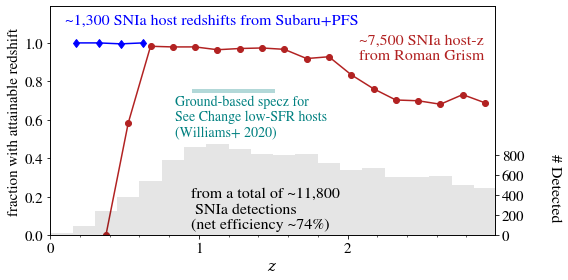

In [13]:
make_hostz_efficiency_fig(roman, subaru, sntype='Ia', field='DEEP', scalefactor=1.35, showseechange=True)
plt.savefig('SNIa_host_z_efficiency_v2.1.pdf',bbox_inches='tight')
#plt.savefig('SNIa_host_z_efficiency.png',bbox_inches='tight')

### Don't trust the CC SN figure

I don't understand why the specz efficiency for CCSN hosts drops so much faster than it does for the Ia host galaxies

In [ ]:
make_hostz_efficiency_fig(roman, subaru, sntype='CC')
plt.savefig('CCSN_host_z_efficiency.pdf',bbox_inches='tight')
plt.savefig('CCSN_host_z_efficiency.png',bbox_inches='tight')